In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE

In [2]:
df = pd.read_csv('manufacturing_defect_dataset.csv')

In [3]:
df.head()

,ProductionVolume,ProductionCost,SupplierQuality,DeliveryDelay,DefectRate,QualityScore,MaintenanceHours,DowntimePercentage,InventoryTurnover,StockoutRate,WorkerProductivity,SafetyIncidents,EnergyConsumption,EnergyEfficiency,AdditiveProcessTime,AdditiveMaterialCost,DefectStatus
0,202,13175.403783,86.648534,1,3.121492,63.463494,9,0.052343,8.630515,0.081322,85.042379,0,2419.616785,0.468947,5.551639,236.439301,1
1,535,19770.046093,86.310664,4,0.819531,83.697818,20,4.908328,9.296598,0.038486,99.657443,7,3915.566713,0.119485,9.080754,353.957631,1
2,960,19060.820997,82.132472,0,4.514504,90.350550,1,2.464923,5.097486,0.002887,92.819264,2,3392.385362,0.496392,6.562827,396.189402,1
3,370,5647.606037,87.335966,5,0.638524,67.628690,8,4.692476,3.577616,0.055331,96.887013,8,4652.400275,0.183125,8.097496,164.135870,1
4,206,7472.222236,81.989893,3,3.867784,82.728334,9,2.746726,6.851709,0.068047,88.315554,7,1581.630332,0.263507,6.406154,365.708964,1


In [4]:
def get_df_info(df):
    print("\n\033[1mShape of DataFrame:\033[0m ", df.shape)
    print("\n\033[1mColumns in DataFrame:\033[0m ", df.columns.to_list())
    print("\n\033[1mData types of columns:\033[0m\n", df.dtypes)
    
    print("\n\033[1mInformation about DataFrame:\033[0m")
    df.info()
    
    print("\n\033[1mNumber of unique values in each column:\033[0m")
    for col in df.columns:
        print(f"\033[1m{col}\033[0m: {df[col].nunique()}")
        
    print("\n\033[1mNumber of null values in each column:\033[0m\n", df.isnull().sum())
    
    print("\n\033[1mNumber of duplicate rows:\033[0m ", df.duplicated().sum())
    
    print("\n\033[1mDescriptive statistics of DataFrame:\033[0m\n", df.describe().transpose())

# Call the function
get_df_info(df)


Shape of DataFrame:  (3240, 17)

Columns in DataFrame:  ['ProductionVolume', 'ProductionCost', 'SupplierQuality', 'DeliveryDelay', 'DefectRate', 'QualityScore', 'MaintenanceHours', 'DowntimePercentage', 'InventoryTurnover', 'StockoutRate', 'WorkerProductivity', 'SafetyIncidents', 'EnergyConsumption', 'EnergyEfficiency', 'AdditiveProcessTime', 'AdditiveMaterialCost', 'DefectStatus']

Data types of columns:
 ProductionVolume          int64
ProductionCost          float64
SupplierQuality         float64
DeliveryDelay             int64
DefectRate              float64
QualityScore            float64
MaintenanceHours          int64
DowntimePercentage      float64
InventoryTurnover       float64
StockoutRate            float64
WorkerProductivity      float64
SafetyIncidents           int64
EnergyConsumption       float64
EnergyEfficiency        float64
AdditiveProcessTime     float64
AdditiveMaterialCost    float64
DefectStatus              int64
dtype: object

Information about DataFrame:
<

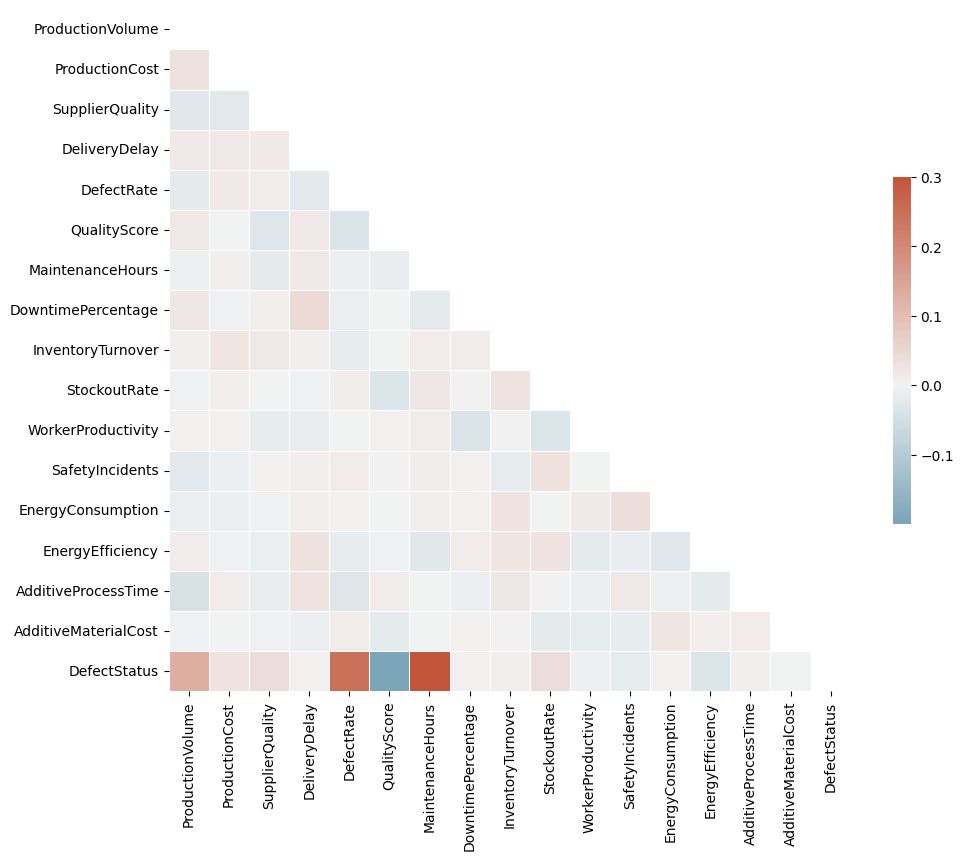

In [5]:
# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

In [6]:
X = df.drop('DefectStatus', axis=1)
y = df['DefectStatus']

In [7]:
def apply_models(X, y):
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Check for class imbalance
    class_counts = np.bincount(y_train)
    if len(class_counts) > 2 or np.min(class_counts) / np.max(class_counts) < 0.1:
      print("Class imbalance detected. Applying SMOTE...")
    
    # Apply SMOTE (class imbalance)
    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)
    
    # Initialize the StandardScaler
    scaler = StandardScaler()

    # Fit the scaler on the training data and transform both training and test data
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Define the models
    models = {
        'LogisticRegression': LogisticRegression(class_weight='balanced'),
        'SVC': SVC(class_weight='balanced'),
        'DecisionTree': DecisionTreeClassifier(class_weight='balanced'),
        'RandomForest': RandomForestClassifier(class_weight='balanced'),
        'ExtraTrees': ExtraTreesClassifier(class_weight='balanced'),
        'AdaBoost': AdaBoostClassifier(),
        'GradientBoost': GradientBoostingClassifier(),
        'XGBoost': XGBClassifier(scale_pos_weight=sum(y_train == 0) / sum(y_train == 1), use_label_encoder=False, eval_metric='logloss'),
        'LightGBM': LGBMClassifier(),
        'CatBoost': CatBoostClassifier(auto_class_weights='Balanced', verbose=0)
    }
    model_performance = {}

    # Apply each model
    for model_name, model in models.items():
        print(f"\n\033[1mClassification with {model_name}:\033[0m\n{'-' * 30}")
        
        # Fit the model to the training data
        model.fit(X_train, y_train)

        # Make predictions on the test data
        y_pred = model.predict(X_test)

        # Calculate the accuracy and f1 score
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')

        # Store the performance in the dictionary
        model_performance[model_name] = (accuracy, f1)

        # Print the accuracy score
        print("\033[1m**Accuracy**:\033[0m\n", accuracy)

        # Print the confusion matrix
        print("\n\033[1m**Confusion Matrix**:\033[0m\n", confusion_matrix(y_test, y_pred))

        # Print the classification report
        print("\n\033[1m**Classification Report**:\033[0m\n", classification_report(y_test, y_pred))

    # Sort the models based on f1 score and pick the top 3
    top_3_models = sorted(model_performance.items(), key=lambda x: x[1][1], reverse=True)[:3]
    print("\n\033[1mTop 3 Models based on F1 Score:\033[0m\n", top_3_models)

    # Extract the model names and classifiers for the top 3 models
    top_3_model_names = [model[0] for model in top_3_models]
    top_3_classifiers = [models[model_name] for model_name in top_3_model_names]

    # Create a Voting Classifier with the top 3 models
    print("\n\033[1mInitializing Voting Classifier with top 3 models...\033[0m\n")
    voting_clf = VotingClassifier(estimators=list(zip(top_3_model_names, top_3_classifiers)), voting='hard')
    voting_clf.fit(X_train, y_train)
    y_pred = voting_clf.predict(X_test)
    print("\n\033[1m**Voting Classifier Evaluation**:\033[0m\n")
    print("\033[1m**Accuracy**:\033[0m\n", accuracy_score(y_test, y_pred))
    print("\n\033[1m**Confusion Matrix**:\033[0m\n", confusion_matrix(y_test, y_pred))
    print("\n\033[1m**Classification Report**:\033[0m\n", classification_report(y_test, y_pred))

    # Create a Stacking Classifier with the top 3 models
    print("\n\033[1mInitializing Stacking Classifier with top 3 models...\033[0m\n")
    stacking_clf = StackingClassifier(estimators=list(zip(top_3_model_names, top_3_classifiers)))
    stacking_clf.fit(X_train, y_train)
    y_pred = stacking_clf.predict(X_test)
    print("\n\033[1m**Stacking Classifier Evaluation**:\033[0m\n")
    print("\033[1m**Accuracy**:\033[0m\n", accuracy_score(y_test, y_pred))
    print("\n\033[1m**Confusion Matrix**:\033[0m\n", confusion_matrix(y_test, y_pred))
    print("\n\033[1m**Classification Report**:\033[0m\n", classification_report(y_test, y_pred))

In [8]:
apply_models(X, y)

/home/user/workspace/.venv/lib/python3.11/site-packages/joblib/externals/loky/backend/context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[Errno 2] No such file or directory: 'lscpu'
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "/home/user/workspace/.venv/lib/python3.11/site-packages/joblib/externals/loky/backend/context.py", line 250, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "/usr/lib/python3.11/subprocess.py", line 1953, in _execute_child
    raise child_exception_type(errno_num, err_msg, 


Classification with LogisticRegression:
------------------------------
**Accuracy**:
 0.7808641975308642

**Confusion Matrix**:
 [[ 74  28]
 [114 432]]

**Classification Report**:
               precision    recall  f1-score   support

           0       0.39      0.73      0.51       102
           1       0.94      0.79      0.86       546

    accuracy                           0.78       648
   macro avg       0.67      0.76      0.68       648
weighted avg       0.85      0.78      0.80       648


Classification with SVC:
------------------------------
**Accuracy**:
 0.8719135802469136

**Confusion Matrix**:
 [[ 66  36]
 [ 47 499]]

**Classification Report**:
               precision    recall  f1-score   support

           0       0.58      0.65      0.61       102
           1       0.93      0.91      0.92       546

    accuracy                           0.87       648
   macro avg       0.76      0.78      0.77       648
weighted avg       0.88      0.87      0.87       64

/home/user/workspace/.venv/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


**Accuracy**:
 0.808641975308642

**Confusion Matrix**:
 [[ 69  33]
 [ 91 455]]

**Classification Report**:
               precision    recall  f1-score   support

           0       0.43      0.68      0.53       102
           1       0.93      0.83      0.88       546

    accuracy                           0.81       648
   macro avg       0.68      0.75      0.70       648
weighted avg       0.85      0.81      0.82       648


Classification with GradientBoost:
------------------------------
**Accuracy**:
 0.9274691358024691

**Confusion Matrix**:
 [[ 79  23]
 [ 24 522]]

**Classification Report**:
               precision    recall  f1-score   support

           0       0.77      0.77      0.77       102
           1       0.96      0.96      0.96       546

    accuracy                           0.93       648
   macro avg       0.86      0.87      0.86       648
weighted avg       0.93      0.93      0.93       648


Classification with XGBoost:
------------------------------